In [1]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.

       Prints the result to stdout and returns the exit status.
       Provides a printed warning on non-zero exit status unless `warn`
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2024-winter/lab1-5.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook()

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Course 236299
## Lab 1-5 – Scaling up: Huggingface Datasets, Tokenizers, and PyTorch

As you've seen, a typical pipeline for NLP applications based on supervised machine learning involves several standard components:

1. Loading of annotated textual corpora.
2. Tokenization and normalization of the text.
3. Distributing instances into subcorpora, for instance, training, development, and test corpora.
4. Training of models on training data, using development data for model selection.
5. Evaluation of the models on test data.

Rather than recapitulate all of these component tasks for each application, standard packages have been developed to facilitate them. In order to facilitate your own experimentation, it's time to make use of some of these packages to scale up your ability to build and test models. That is the subject of this lab.

[Huggingface](https://huggingface.co) is a supplier of open tools for a variety of machine learning applications. Huggingface's `datasets` and `tokenizers` libraries provide a uniform system for establishing dataset objects that contain multiple examples, each of which may have multiple features. These libraries provide functions to preprocess, tokenize, or postprocess the data. Dataset objects can be easily split into parts (training and test, for instance), or turned into a sequence of small batches for processing by models. Most importantly, as you will see in future labs, these data loading libraries can be easily integrated with Huggingface's `transformers` library which is widely used in NLP applications these days.

This lab provides an introduction to using `datasets`, `tokenizers`, and PyTorch in preparation for its appearance in later labs and homework problem sets.

After this lab, you should be able to

* Read data loading code implemented using `datasets` and `tokenizers` and understand what it is intending to accomplish.
* Run experiments training and testing simple feed-forward neural networks using PyTorch.

New bits of Python used for the first time in the *distribution version* of this lab include:

* Datasets
    * [`datasets.load_dataset`](https://huggingface.co/docs/datasets/loading)

    * [`datasets.Dataset`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset)
    * `datasets.Dataset.shuffle`
    * `datasets.Dataset.train_test_split`
    * `datasets.Dataset.add_column`
    * `datasets.Dataset.map`
    * `datasets.Dataset.class_encode_column`
    * `datasets.Dataset.align_labels_with_mapping`
   
* Tokenizers
    * [`tokenizers.Tokenizer`](https://huggingface.co/docs/tokenizers/pipeline)
    * `tokenizer.Tokenizer.encode`
    * `tokenizer.Tokenizer.decode`
    * `tokenizer.Tokenizer.get_vocab`
    * `tokenizer.Tokenizer.train_from_iterator`
    * `tokenizer.processors.TemplateProcessing`

* Transformers
    * [`transformers.PreTrainedTokenizerFast`](https://huggingface.co/docs/transformers/fast_tokenizers)
    
* Torch
    * [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html)
    * [`torch.nn.Module.eval`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval)
    * `torch.nn.Linear`
    * `torch.nn.Sigmoid`
    * `torch.distributions.normal.Normal`
    * `torch.distributions.uniform.Uniform`


* `tqdm.tqdm` (for generating progress bars)

New bits of Python used for the first time in the *solution set* for this lab, and which you may therefore find useful:

* [`torch.Tensor.backward`](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.backward)
* [`torch.optim.Optimizer.step`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html#torch.optim.Optimizer.step)

# Preparation – Loading packages and data {-}

In [3]:
import copy
import math
import random
import matplotlib.pyplot as plt
import os
import re
import sys
import warnings
import wget
import csv

import torch
import torch.distributions as ds
import torch.nn as nn
import torch.nn.functional as F
import datasets

from copy import deepcopy

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer

from transformers import PreTrainedTokenizerFast

from torch import optim
from tqdm import tqdm

In [4]:
# Set up plotting
plt.style.use('tableau-colorblind10')

# Fix random seed for replicability
random_seed = 1234
random.seed(random_seed)
torch.manual_seed(random_seed)

## GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Manipulating text corpora with `datasets`

You'll use Huggingface's `datasets` to load the _Green Eggs and Ham_ (GEaH) dataset.

We start with reading in the data and performing some ad hoc cleaning (removing comment lines and blank lines).

In [5]:
def strip_file(text):
    """strip #comments and empty lines from `text` string"""
    result = ""
    for line in text.split("\n"):
        line = line.strip()              # trim whitespace
        line = re.sub('#.*$', '', line)  # trim comments
        if line != '':                   # drop blank lines
            result += line + '\n'
    return result

# Read the GEaH data and write out a corresponding CSV file
os.makedirs('data', exist_ok=True)
wget.download("https://github.com/nlp-236299/data/raw/master/Seuss/seuss - 1960 - green eggs and ham.txt", out="data/")
with open('data/seuss - 1960 - green eggs and ham.txt', 'r') as fin:
    with open('data/geah.csv', 'w') as fout:
        writer = csv.writer(fout)
        writer.writerow(('label','text'))
        text = strip_file(fin.read())
        for line in text.strip().split('\n'):
            label, text = line.split('\t')
            writer.writerow((label, text))

## Constructing training and test datasets

Take a look at the file `geah.csv`, which we've just processed and placed into the sibling `data` folder.

In [6]:
shell('head "data/geah.csv"')

label,text
SAM,I am Sam.
SAM,I am Sam.
SAM,Sam I am.
GUY,That Sam-I-am!
GUY,That Sam-I-am!
GUY,I do not like that Sam-I-am!
SAM,Do you like green eggs and ham?
GUY,"I do not like them, Sam-I-am."
GUY,I do not like green eggs and ham.


Notice the structure of this corpus. Each line contains a sentence from the book, preceded by a label that provides the speaker of that sentence. The speaker and sentence are separated by a comma. The data is thus set up properly for using Huggingface's [`datasets.load_dataset`](https://huggingface.co/docs/datasets/loading) using its `"CSV"` (comma-separated values) format.

Now, you can set up the dataset using [`load_dataset`](https://huggingface.co/docs/datasets/loading). It should look for the CSV data in the file `data/geah.csv`, and should pass the argument `split='all'` such that a `dataset.Dataset` object instead of `dataset.DatasetDict` is returned. We'll call the dataset `geah`.

<!--
BEGIN QUESTION
name: dataset_setup
-->

In [7]:
#TODO: Set up the dataset using `load_dataset`. You should pass
# `split='all'` such that a `dataset.Dataset` object is returned.
geah = load_dataset("csv", data_files="data/geah.csv", split='all')

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
grader.check("dataset_setup")

All tests passed!

We can see that the loaded dataset has two features: label and text.

In [9]:
geah

Dataset({
    features: ['label', 'text'],
    num_rows: 139
})

We can access examples from this dataset simply by indexing it similar to how we index a Python list.

In [10]:
# The first example
geah[0]

{'label': 'SAM', 'text': 'I am Sam.'}

In [11]:
# The second to the fifth examples
geah[1:5]

{'label': ['SAM', 'SAM', 'GUY', 'GUY'],
 'text': ['I am Sam.', 'Sam I am.', 'That Sam-I-am!', 'That Sam-I-am!']}

All [`dataset.Dataset`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset) objects have a [`train_test_split`](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.train_test_split) method that splits the dataset into two pieces, for instance, to have a separate training and test set. Use the `train_test_split` method to generate a 70%/30% split of the GEaH corpus into two subsets called `train` and `test`. You should pass `seed=random_seed` to make sure the splitting is deterministic and to pass the unit tests.
<!--
BEGIN QUESTION
name: dataset_split
-->

In [12]:
#TODO: Split geah into 70% training data and 30% test data
# Make sure to pass `random_seed` as the seed.
train_test = geah.train_test_split(test_size=0.3, seed=random_seed)
train = train_test['train']
test = train_test['test']

In [13]:
grader.check("dataset_split")

All tests passed!

For the label feature, we can convert it to integer label ids to facilitate processing it with models such as neural networks using [`datasets.Dataset.class_encode_column`](https://huggingface.co/docs/datasets/v2.12.0/en/package_reference/main_classes#datasets.Dataset.class_encode_column).

In [14]:
train = train.add_column('label_id', train['label'])
test = test.add_column('label_id', test['label'])
train = train.class_encode_column('label_id')

label2id = train.features['label_id']._str2int
test = test.class_encode_column('label_id')
test = test.align_labels_with_mapping(label2id, "label_id")

Flattening the indices:   0%|          | 0/97 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/42 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/97 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/42 [00:00<?, ? examples/s]

Aligning the labels:   0%|          | 0/42 [00:00<?, ? examples/s]

The new feature `label_id` stores the label ids.

In [15]:
train[1:5]

{'label': ['GUY', 'SAM', 'SAM', 'SAM'],
 'text': ['I do!',
  'Do you like green eggs and ham?',
  'A train!',
  'You may like them.'],
 'label_id': [0, 1, 1, 1]}

## Tokenization

Now let's turn our attention to text features. As we have explored in lab 1-1, text can be represented as a sequence of integer word ids. In Huggingface datasets, we need to create a tokenizer which both specifies how to tokenize text into a sequence of tokens and also internally maintains a _vocabulary_ which establishes the mapping from types to indices. We will use the training corpus to establish the vocabulary.

In [16]:
unk_token = '[UNK]' # a token representing unknown (out-of-vocabulary) tokens
pad_token = '[PAD]' # a padding token

# Instantiate a tokenizer
tokenizer = Tokenizer(WordLevel(unk_token=unk_token))  # WordLevel is a simple tokenization model
                                                       # that doesn't split the words
tokenizer.pre_tokenizer = Whitespace()                 # pre-tokenizer splits the text into words
tokenizer.normalizer = normalizers.Lowercase()         # normalizer lowercases the text

# Build the vocabulary from training data
trainer = WordLevelTrainer(special_tokens=[pad_token, unk_token]) # trainer is responsible for
                                                                  # building the vocabulary
tokenizer.train_from_iterator(train['text'], trainer=trainer)

Let's try out the tokenizer on some examples.

In [17]:
encoded = tokenizer.encode('I am Sam.')
print (f'tokens: {encoded.tokens}')
print (f'word ids: {encoded.ids}')
print (f'converted back: {tokenizer.decode(encoded.ids, skip_special_tokens=False)}')

tokens: ['i', 'am', 'sam', '.']
word ids: [3, 19, 16, 2]
converted back: i am sam .


In [18]:
encoded = tokenizer.encode('An example with many unknown tokens.')
print (f'tokens:         {encoded.tokens}')
print (f'word ids:       {encoded.ids}')
print (f'converted back: {tokenizer.decode(encoded.ids, skip_special_tokens=False)}')

tokens:         ['[UNK]', '[UNK]', 'with', '[UNK]', '[UNK]', '[UNK]', '.']
word ids:       [1, 1, 20, 1, 1, 1, 2]
converted back: [UNK] [UNK] with [UNK] [UNK] [UNK] .


### A digression: Postprocessing

In future labs we will also use `tokenizer.post_processor` which can be used to post-process the tokenized text. In the following example we will add exclamation points `!` in the beginning and end of the tokenized text using [TemplateProcessing](https://huggingface.co/docs/tokenizers/v0.13.3/en/api/post-processors#tokenizers.processors.TemplateProcessing).

In [19]:
exclamation_point = '!'
post_processing_tokenizer = deepcopy(tokenizer) # we clone the tokenizer for this example
post_processing_tokenizer.post_processor = \
  TemplateProcessing(single=f"{exclamation_point} $A {exclamation_point}",
                     special_tokens=[(exclamation_point,
                                      post_processing_tokenizer.token_to_id(exclamation_point))])

encoded = post_processing_tokenizer.encode('I am Sam.')
print (f'tokens: {encoded.tokens}')
print (f'word ids: {encoded.ids}')
print (f'converted back: {post_processing_tokenizer.decode(encoded.ids, skip_special_tokens=False)}')

tokens: ['!', 'i', 'am', 'sam', '.', '!']
word ids: [7, 3, 19, 16, 2, 7]
converted back: ! i am sam . !


With a tokenizer, we can convert text strings into integer word ids using `datasets.Dataset.map`. But first we need to wrap `tokenizer` with the [`transformers.PreTrainedTokenizerFast`](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast) class. `transformers.PreTrainedTokenizerFast` provide a convenient interface for tokenizers that are compatible with PyTorch tensors.

In [20]:
hf_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer,
                                       pad_token=pad_token,
                                       unk_token=unk_token)

This `hf_tokenizer` takes in a text string and converts it to a sequence of word ids stored in `input_ids` of the returned dictionary. (You can ignore `token_type_ids` and `attention_mask` for now.)

In [21]:
text = 'I am Sam.'
hf_tokenizer(text)

{'input_ids': [3, 19, 16, 2], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

We can use the `hf_tokenizer` to get a list of tokens.

In [22]:
hf_tokenizer.tokenize(text)

['i', 'am', 'sam', '.']

`hf_tokenizer` can also be used to decode some encoded text.

In [23]:
encoded_text = hf_tokenizer(text).input_ids
decoded_text = hf_tokenizer.decode(encoded_text)
decoded_tokens = hf_tokenizer.convert_ids_to_tokens(encoded_text)
print(f"text: {text}")
print(f"encoded text: {encoded_text}")
print(f"decoded text: {decoded_text}")
print(f"decoded token list: {decoded_tokens}")

text: I am Sam.
encoded text: [3, 19, 16, 2]
decoded text: i am sam .
decoded token list: ['i', 'am', 'sam', '.']


Note that `hf_tokenizer` also stores the vocabulary and the special tokens we provided it in the initialization.

In [24]:
print(f"hf_tokenizer.unk_token: {hf_tokenizer.unk_token}")
print(f"hf_tokenizer.unk_token_id: {hf_tokenizer.unk_token_id}")
print(f"hf_tokenizer.pad_token: {hf_tokenizer.pad_token}")
print(f"hf_tokenizer.pad_token_id: {hf_tokenizer.pad_token_id}")
print(f"hf_tokenizer.get_vocab():\n {hf_tokenizer.get_vocab()}")
print(f"len(hf_tokenizer) == len(hf_tokenizer.get_vocab()): {len(hf_tokenizer)}")

hf_tokenizer.unk_token: [UNK]
hf_tokenizer.unk_token_id: 1
hf_tokenizer.pad_token: [PAD]
hf_tokenizer.pad_token_id: 0
hf_tokenizer.get_vocab():
 {'mouse': 32, 'boat': 56, 'like': 8, 'with': 20, '.': 2, 'good': 51, 'green': 26, 'may': 45, ',': 9, 'thank': 52, 'could': 22, 'and': 13, 'dark': 31, 'i': 3, 'say': 38, '...': 55, 'try': 39, '[PAD]': 0, 'anywhere': 40, 'or': 34, 'will': 18, 'they': 53, 'house': 35, 'so': 36, 'eggs': 25, 'eat': 15, 'train': 28, 'if': 57, 'sam': 16, 'here': 23, 'be': 41, 'tree': 54, 'fox': 42, 'in': 11, 'see': 48, 'me': 46, 'that': 49, '-': 14, 'box': 37, '?': 21, '!': 7, '[UNK]': 1, 'the': 24, 'would': 17, 'do': 10, 'a': 6, 'are': 50, 'car': 30, 'not': 4, 'on': 33, 'them': 5, 'am': 19, 'there': 29, 'ham': 27, 'goat': 43, 'let': 44, 'rain': 47, 'you': 12}
len(hf_tokenizer) == len(hf_tokenizer.get_vocab()): 58


Now we can convert the training and test sets into word ids using [`datasets.Dataset.map`](https://huggingface.co/docs/datasets/v2.12.0/en/package_reference/main_classes#datasets.Dataset.map).

In [25]:
def encode(example):
    return hf_tokenizer(example['text'])

train = train.map(encode)
test = test.map(encode)

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Let's take a look at one example from the mapped dataset. The new feature `input_ids` contain the word ids.

In [26]:
train[0]

{'label': 'SAM',
 'text': 'Would you like them in a house?',
 'label_id': 1,
 'input_ids': [17, 12, 8, 5, 11, 6, 35, 21],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

Again, we can view several examples at once.

In [27]:
train[1:5]

{'label': ['GUY', 'SAM', 'SAM', 'SAM'],
 'text': ['I do!',
  'Do you like green eggs and ham?',
  'A train!',
  'You may like them.'],
 'label_id': [0, 1, 1, 1],
 'input_ids': [[3, 10, 7],
  [10, 12, 8, 26, 25, 13, 27, 21],
  [6, 28, 7],
  [12, 45, 8, 5, 2]],
 'token_type_ids': [[0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0],
  [0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1],
  [1, 1, 1, 1, 1]]}

The text and label features now have vocabularies that maps the elements of the vocabulary to integer index representations of the elements, accessible via the below code.

In [28]:
text_vocab = tokenizer.get_vocab()
label_vocab = train.features['label_id']._str2int

In [29]:
label_vocab

{'GUY': 0, 'SAM': 1}

In [30]:
text_vocab

{'the': 24,
 'do': 10,
 'good': 51,
 '[PAD]': 0,
 'they': 53,
 '[UNK]': 1,
 'will': 18,
 'car': 30,
 'fox': 42,
 'a': 6,
 'them': 5,
 'try': 39,
 'anywhere': 40,
 'or': 34,
 'on': 33,
 'be': 41,
 'may': 45,
 'and': 13,
 'would': 17,
 '!': 7,
 'with': 20,
 'in': 11,
 'that': 49,
 'box': 37,
 'me': 46,
 'rain': 47,
 'see': 48,
 'there': 29,
 'mouse': 32,
 'not': 4,
 'dark': 31,
 '-': 14,
 'you': 12,
 'here': 23,
 'eggs': 25,
 'tree': 54,
 'eat': 15,
 'thank': 52,
 'train': 28,
 'ham': 27,
 'house': 35,
 'goat': 43,
 'i': 3,
 'sam': 16,
 'could': 22,
 ',': 9,
 'green': 26,
 'let': 44,
 'so': 36,
 'say': 38,
 '...': 55,
 'are': 50,
 'if': 57,
 'am': 19,
 '?': 21,
 'boat': 56,
 '.': 2,
 'like': 8}

How many elements are there in these vocabularies? You can use the `len` function to find out.
<!--
BEGIN QUESTION
name: vocab_sizes
-->

In [31]:
#TODO: Calculate the sizes of label_vocab and text_vocab
label_vocab_size = len(label_vocab)
text_vocab_size = len(text_vocab)

In [32]:
grader.check("vocab_sizes")

All tests passed!

In [33]:
print(f"label vocabulary size is {label_vocab_size}\n"
      f"text vocabulary size is {text_vocab_size}")

label vocabulary size is 2
text vocabulary size is 58


## Operations over datasets

We now have training and test datasets. You can experiment with the kinds of operations you'll need to do to implement models like Naive Bayes or logistic regression.

For instance, you can inspect an example from the dataset.

In [34]:
example = train[1] # the second instance
print (f"text: {example['text']}\n"
       f"label: {example['label']}")

text: I do!
label: GUY


You might also need to iterate over the different class labels (`label_vocab`) or the word types (`text_vocab`). Define a function that iterates over a vocabulary and prints each one out in alphabetical order along with their corresponding ids like this:

```
>>> print_vocab(label_vocab)
GUY: 0
SAM: 1
```

<!--
BEGIN QUESTION
name: print_vocab
-->

In [35]:
#TODO: print out vocabulary in alphabetical order with ids
def print_vocab(vocab):
    for word in sorted(vocab): # gets a sorted *list* of the *keys* od the input dictionary
        print(f"{word}: {vocab[word]}")

In [36]:
grader.check("print_vocab")

All tests passed!

 We can use the `print_vocab` function to print out the different class labels.

In [37]:
print_vocab(label_vocab)

GUY: 0
SAM: 1


Similarly, we can also print out `text_vocab`.

In [38]:
print_vocab(text_vocab)

!: 7
,: 9
-: 14
.: 2
...: 55
?: 21
[PAD]: 0
[UNK]: 1
a: 6
am: 19
and: 13
anywhere: 40
are: 50
be: 41
boat: 56
box: 37
car: 30
could: 22
dark: 31
do: 10
eat: 15
eggs: 25
fox: 42
goat: 43
good: 51
green: 26
ham: 27
here: 23
house: 35
i: 3
if: 57
in: 11
let: 44
like: 8
may: 45
me: 46
mouse: 32
not: 4
on: 33
or: 34
rain: 47
sam: 16
say: 38
see: 48
so: 36
thank: 52
that: 49
the: 24
them: 5
there: 29
they: 53
train: 28
tree: 54
try: 39
will: 18
with: 20
would: 17
you: 12


Other simple calculations that will be useful in implementing the various models:

1. Counting how many instances there are in a dataset.
2. Counting how many instances of a certain class there are in a dataset.
3. Counting how many tokens of a certain type there are in the text of an instance.

Let's write functions for these. They'll come in handy in the first problem set.

<!--
BEGIN QUESTION
name: count_instances
-->

In [39]:
#TODO - 1. Counting how many instances there are in a dataset.
def count_instances(dataset):
    return len(dataset)

In [40]:
grader.check("count_instances")

All tests passed!

In [41]:
#TODO - 2. Counting how many instances of a certain class there are in a dataset.
# Note: recall that you can access the label of an instance using `instance['label']`
def count_instances_class(dataset, label):
    return len([instance for instance in dataset if instance['label'] == label])

In [42]:
grader.check("count_instances_class")

All tests passed!

In [43]:
#TODO - 3. Counting how many tokens of a certain type there are in the text of an instance.
# Hint: we have provided code for extracting tokens from the text of an instance.
def count_tokens_instance(instance, tokentype):
    tokens = tokenizer.encode(instance['text']).tokens
    return tokens.count(tokentype)

In [44]:
grader.check("count_tokens_instances")

All tests passed!

Recall that the purpose of these tokenizer objects is to map back and forth between strings and word ids. Below provides an example of how to do that.

In [45]:
example = train[1]
print (f'text: {example["text"]}')
word_ids = example['input_ids']
print (f"Mapped to word ids: {word_ids}\n"
       f"Mapped back: {hf_tokenizer.decode(word_ids)}")

text: I do!
Mapped to word ids: [3, 10, 7]
Mapped back: i do !


We can also do the conversion for a batch of examples, which will be very useful in future labs when we take advantage of the parallelism provided by parallel hardware such as GPUs.

In [46]:
examples = train[1:5]
print (f'text: {examples["text"]}')
word_ids_batch = examples['input_ids']
print (f"Mapped to word ids: {word_ids_batch}\n"
       f"Mapped back: {hf_tokenizer.batch_decode(word_ids_batch)}\n"
       f"Mapped back skipping padding: {hf_tokenizer.batch_decode(word_ids_batch, skip_special_tokens=True)}")

text: ['I do!', 'Do you like green eggs and ham?', 'A train!', 'You may like them.']
Mapped to word ids: [[3, 10, 7], [10, 12, 8, 26, 25, 13, 27, 21], [6, 28, 7], [12, 45, 8, 5, 2]]
Mapped back: ['i do !', 'do you like green eggs and ham ?', 'a train !', 'you may like them .']
Mapped back skipping padding: ['i do !', 'do you like green eggs and ham ?', 'a train !', 'you may like them .']


You might have noticed that in the above example, different sentences are of different lengths. This makes it hard for processing on parallel hardware, and we need to *pad* all sentences to the length of the longest sentence in each batch before converting them to tensors, as shown below. (You will see the below code in project 1 and in future labs.)

In [47]:
pad_id = hf_tokenizer.pad_token_id
BATCH_SIZE = 32

# Defines how to batch a list of examples together
def collate_fn(examples):
    batch = {}
    bsz = len(examples)
    label_ids = []
    for example in examples:
        label_ids.append(example['label_id'])
    label_batch = torch.LongTensor(label_ids).to(device)
    input_ids = []
    for example in examples:
        input_ids.append(example['input_ids'])
    max_length = max([len(word_ids) for word_ids in input_ids])
    text_batch = torch.zeros(bsz, max_length).long().fill_(pad_id).to(device)
    for b in range(bsz):
        text_batch[b][:len(input_ids[b])] = torch.LongTensor(input_ids[b]).to(device)

    batch['label_ids'] = label_batch
    batch['input_ids'] = text_batch
    return batch

train_iter = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_iter = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_fn)

Let's look at a single batch from one of these iterators. Each sentence is the same length, with padding as needed with the `PAD` token, which has id `0`.

In [48]:
next(iter(train_iter))

{'label_ids': tensor([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([[17, 12,  8,  5, 11,  6, 35, 21,  0,  0],
         [ 3, 10,  7,  0,  0,  0,  0,  0,  0,  0],
         [10, 12,  8, 26, 25, 13, 27, 21,  0,  0],
         [ 6, 28,  7,  0,  0,  0,  0,  0,  0,  0],
         [12, 45,  8,  5,  2,  0,  0,  0,  0,  0],
         [ 3, 18,  4, 15,  5, 11, 24, 47,  2,  0],
         [17, 12,  8,  5, 23, 34, 29, 21,  0,  0],
         [16,  7,  0,  0,  0,  0,  0,  0,  0,  0],
         [13, 11,  6, 30,  2, 13, 11,  6, 54,  2],
         [12, 10,  4,  8, 26, 25, 13, 27, 21,  0],
         [ 4, 33,  6, 28,  7,  0,  0,  0,  0,  0],
         [ 3, 10,  4,  8, 26, 25, 13, 27,  2,  0],
         [12, 18, 48,  2,  0,  0,  0,  0,  0,  0],
         [22, 12, 21,  0,  0,  0,  0,  0,  0,  0],
         [ 3, 10,  4,  8,  5, 23, 34, 29,  2,  0],
         [39,  5, 13, 12, 45,  9,  3, 38,  2,  0],
         [36, 12, 38,  2,  0,  0,  0,  0, 

# Training and testing with PyTorch

Past labs have shown that all of the detail about

* establishing models and their parameters,
* using them to calculate the outputs for some inputs,
* training them to optimize the parameters via stochastic gradient descent, and
* evaluating them by testing on held-out data

is tedious to manage. Fortunately, it is also so formulaic, at least for a certain class of models, that general tools can be deployed to manage the process. In the remainder of this lab, you'll use one such tool, PyTorch. For simplicity, rather than a natural-language task, you'll be training a model to fit a curve; it has an especially simple structure: one scalar input and one scalar output.

## Generating training and test data

We start by generating some training and test data. The data is generated as a noisy sine function, calculated by the function `sinusoid`. (Here we make use of the PyTorch [distributions](https://pytorch.org/docs/stable/distributions.html) package, which was imported above as `ds`.)

In [49]:
def sinusoid(x, amplitude=1., phase=0., frequency=1., noise=1e-5):
    """Returns the values on input(s) `x` of a sinusoid determined by `amplitude`,
       `phase`, and angular `frequency`, with some added normal noise with variance
       given by `noise`."""
    normal_noise = ds.normal.Normal(torch.tensor([0.0]), torch.tensor([noise]))
    noise_sample = normal_noise.sample(x.size()).view(-1)
    y = amplitude * torch.sin(x * frequency + phase) + noise_sample
    return y

We can generate data for training and testing by sampling this function.

In [50]:
def sample_input(func, count, bound, **kwargs):
    """Returns `count` samples of x-y pairs of function `func`, with the x
       values sampled uniformly between +/-`bound`. The `kwargs` are passed
       on to `func`."""
    input_unif = ds.uniform.Uniform(-bound, +bound)
    x = input_unif.sample(torch.Size([count]))
    y = func(x, **kwargs)
    return x, y

To give a sense of what a data sample looks like, we plot a sample of 100 points.

In [51]:
def plot_sample(data):
    """Plots `data` given as a single pair of inputs and outputs."""
    X, Y = data
    plt.plot(X.tolist(), Y.tolist(), '.')
    plt.xlabel('Input')
    plt.ylabel('Output')
    # we cannot use plt.show() because otter-grader does not support it

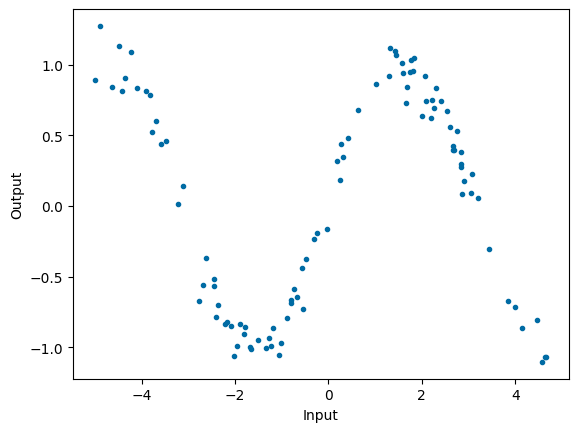

In [52]:
plot_sample(sample_input(sinusoid, 100, 5, noise=0.1))

## Specifying a feed-forward neural network


<img src="https://github.com/nlp-236299/data/raw/master/Resources/ffnn-example.png" width=33% align=right />

The model that we will train to predict the output of this function based on a sample will consist of a series of sublayers as depicted in the figure at right. At the bottom of the figure, we start with $\vect{x}$, the scalar input (of dimensionality $1$ as shown in the "shape" designation). The first layer is a perceptron layer, composed of a linear sublayer (with weights $\vect{U}$) followed by a sigmoid sublayer. Since $\vect{U}$ is of dimensionality $1 \times D$, the output is a vector of dimensionality $D$. (We refer to $D$ as the *hidden dimension*.) Then comes another perceptron layer with input and output each of dimensionality $D$. Finally, a single linear layer reduces the dimensionality back to the predicted scalar output $\tilde{y}$ of dimensionality $1$. The loss is calculated as the mean square error of $\tilde{y}$ relative to $y$. (In this case, taking the mean for a single example is irrelevant, since $y$ is a scalar, though when training in "batches", the mean would be taken over the batch.)

We define a class `FFNN` (**f**eed-**f**orward **n**eural **n**etwork), which inherits from the `nn.Module` class, PyTorch's class for neural network models. It takes an argument `hidden_dim` which is the size of the hidden layers, $D$ in the figure.

The parameters of this model – the values that will be adjusted to minimize the loss – are the elements of the tensors $\vect{U}$, $\vect{V}$, and $\vect{W}$. They don't appear explicitly in the code, but are PyTorch *parameters* created and tracked when the corresponding sublayers are created using `nn.Linear`. That's the wonder of using PyTorch – so much happens under the hood. But we can get access to the parameters because the `nn.Module` class provides a `parameters` method that returns an iterator over the parameters. (We use it to initialize the parameters to random values.)


<!--
BEGIN QUESTION
name: FFNN
-->

In [53]:
class FFNN(nn.Module):
    def __init__(self, hidden_dim, init_low=-2, init_high=2):
        super().__init__()
        # dimensionality of hidden layers
        self.hidden_dim = hidden_dim
        # establishing the sublayers -- two perceptrons (each with a linear
        # layer and a sigmoid) and a final linear layer -- and their parameters
        self.sublayer1 = nn.Linear(1, hidden_dim)          # U: 1 X D
        self.sublayer2 = nn.Sigmoid()
        self.sublayer3 = nn.Linear(hidden_dim, hidden_dim) # V: D X D
        self.sublayer4 = nn.Sigmoid()
        self.sublayer5 = nn.Linear(hidden_dim, 1)          # W: D X 1

        # initialize parameters randomly
        torch.manual_seed(random_seed)
        for p in self.parameters():
            p.data.uniform_(init_low, init_high)
        # save a copy of the parameters to allow resetting
        self.init_state = copy.deepcopy(self.state_dict())

    # Resetting state: If you want to rerun a model, say, with a different
    # training regime, you can reset the model's parameter state using
    #    model.reset_state()
    # before retraining, e.g.,
    #    train_model(model, criterion, optim, train_data, n_epochs=50)
    def reset_state(self):
        self.load_state_dict(self.init_state)

    def forward(self, x):
        # first perceptron layer
        z = self.sublayer2(self.sublayer1(x))
        # second perceptron layer
        z_prime = self.sublayer4(self.sublayer3(z))
        # final linear layer
        return self.sublayer5(z_prime)

We can build a model by instantiating the `FFNN` class. We'll do so with a hidden dimension of 4, being careful to move the model with its parameters to the device we're using for calculations (a GPU if one is available, as on Google Colab).

In [54]:
HIDDEN_DIMENSION = 4
model = FFNN(HIDDEN_DIMENSION).to(device)

We specify the criterion to be optimized as the mean square error loss function provided by PyTorch.

In [55]:
criterion = nn.MSELoss(reduction='mean')

## Evaluating data according to a model

To evaluate how well the model performs on some test data, we run the model forward on the $x$ values and compute the loss relative to the $y$ values. We define a function `eval_model` to carry out this calculation.

In [56]:
def eval_model(model, criterion, data):
    """Applies the `model` to the x values in the `data` and returns the
       loss relative to the y values in the `data` along with the predicted
       y values."""
    model.eval()                          # turn on evaluation mode
    with torch.no_grad():                 # turn off propagating gradients
        X, Y = data                       # extract x and y values
        X = X.view(-1, 1).to(device)      # convert x and y to column vectors
        Y = Y.view(-1, 1).to(device)      # ...and move them to the device
        predictions = model(X)            # calculate the predicted y values
        loss = criterion(predictions, Y)  # see how far off they are
    return loss.item(), predictions

All that remains is training the model. We'll use one of PyTorch's built in optimizers, the `Adam` optimizer. We set a few parameters for the training process: the learning rate, the number of "epochs" (passes through the training data) to perform, and the number of examples to train on at a time (the "batch size").

In [57]:
## Parameters of the training regimen
LEARNING_RATE = 0.003
NUMBER_EPOCHS = 25
BATCH_SIZE = 20

## Choices for optimizers:

# Stochastic Gradient Descent (SGD) optimizer
# optim = torch.optim.SGD(model.parameters(), lr=learning_rate)

# The Adam optimizer, as described in the paper:
# Kingma and Ba. 2014. Adam: A Method for Stochastic Optimization.
# [https://arxiv.org/abs/1412.6980]
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training the parameters of a model

Finally, we get to the function to train the parameters of the model so as to best fit the predictions to the actual values. We've provided the code, except for a few lines that you'll need to provide (marked `#TODO`), making use of some of the tools defined above. Those lines, which form the heart of the computation, calculate "forwards" to get the output predictions for the inputs, calculate the loss for those predictions, and calculate "backwards" the gradients of the loss for each of the parameters of the model. This sets up the optimizer to take a step of updating the parameters, making use of the calculated gradients to determine the direction to step. The saved gradients can then be zeroed and the process repeated.

> Note: The code we're asking you to write is *tiny*. If you find yourself writing more than a short line of code per `#TODO`, you're missing something.

In [58]:
def train_model(model, criterion, optimizer, data,
                n_epochs=NUMBER_EPOCHS, batch_size=BATCH_SIZE):
    """Optimizes the parameters of the `model` by minimizing the `criterion`
       on the training `data`, using the `optimizer` algorithm for updates."""
    model.train()                     # Turn on training mode

    X, Y = data
    trainX_len = len(X)

    loss_per_epoch = math.inf
    with tqdm(range(n_epochs)) as pbar:
        for epoch in pbar:
            pbar.set_postfix(epoch=epoch+1, loss=loss_per_epoch)
            loss_per_epoch = 0.
            for batch_i in range(int(trainX_len/batch_size)):
                optimizer.zero_grad()     # new batch; zero the gradients of the parameters

                # Input tensors and their corresponding output values for this batch
                batch_X = (X[batch_i * batch_size
                             : (batch_i+1) * batch_size] # extract examples in batch
                           .view(-1, 1)                  # reshape to column vector
                           .to(device)                   # move to device
                          )
                batch_Y = (Y[batch_i * batch_size
                             : (batch_i+1) * batch_size]
                           .view(-1, 1)
                           .to(device)
                          )

                #TODO: Calculate predictions for the x values in this batch
                predictions = model(batch_X)

                #TODO: Calculate the loss for the predictions
                loss = criterion(predictions, batch_Y)

                #TODO: Perform backpropagation to calculate gradients
                loss.backward()

                # Update all parameters
                optimizer.step()

                loss_per_epoch += loss.item()

## Putting it all together

Let's try it out. We start by generating some training and test data. The training data will be 10,000 samples of a noisy sinusoid. The test data, 100 samples from the same sinusoid, will be noise-free, so we can see how close the predictions are to noise-free outputs.

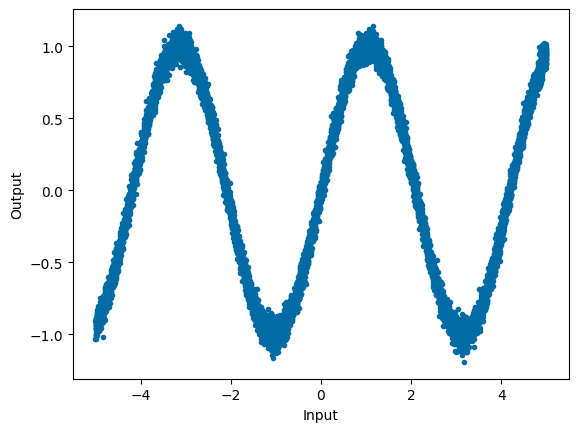

In [59]:
train_data = sample_input(sinusoid, 10000, 5., frequency=1.5, noise=0.05)
test_data = sample_input(sinusoid, 100, 5., frequency=1.5)

plot_sample(train_data)

We train the model.

In [60]:
model.reset_state()
train_model(model, criterion, optim, train_data)

100%|██████████| 25/25 [00:18<00:00,  1.37it/s, epoch=25, loss=11.1]


...and test the trained model by evaluating it on the the test data.

In [61]:
loss, predictions = eval_model(model, criterion, test_data)

In [67]:
print(f"{loss = }")

loss = 0.013471275568008423


In [62]:
grader.check("model_reduces_loss")

All tests passed!

We can see how well the model works by plotting the test data (circles) along with the predicted values (crosses).

In [63]:
def visualize_predictions(data, predictions):
    X, Y = data

    # Plot the actual output values
    plt.plot(X.tolist(), Y.tolist(), '.', label = 'Target Values')

    # Plot the predicted output values
    predictions = predictions.view(-1, 1)
    plt.plot(X.tolist(), predictions.tolist(), 'x', label = 'Predictions')

    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.legend()
    # we cannot use plt.show() because otter-grader does not support it

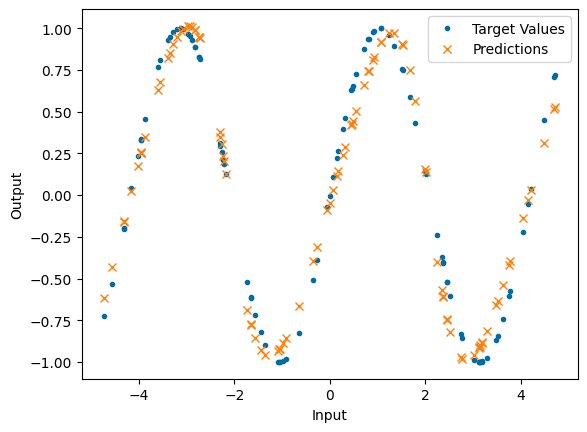

In [64]:
# Visualize the predictions
visualize_predictions(test_data, predictions)

## Trying different models

Now that we have the infrastructure, try experimenting with different models. Here are a few things you might play with. (No need to try them all.) What happens if you change the hidden dimension, increasing it to 8 or decreasing it to 2? What happens if you drop the middle layer? What about no middle layer but a much higher hidden dimension size? Does running for more epochs improve performance? Does the SGD optimizer work better or worse than the Adam optimizer?

**Perform any experimentation in cells below this point, so you don't modify the cells above that are being unit tested.**

In [76]:
# training different models
all_losses = {}

# First, we'll examine different Hidden Dimensions with an ADAM optimizer
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

HIDDEN_DIMENSION = 2
model_2 = FFNN(HIDDEN_DIMENSION).to(device)
model_2.reset_state()
train_model(model_2, criterion, optim, train_data)
loss_adam_2, _ = eval_model(model_2, criterion, test_data)
all_losses['adam_2'] = loss_adam_2

HIDDEN_DIMENSION = 4
model_4 = FFNN(HIDDEN_DIMENSION).to(device)
model_4.reset_state()
train_model(model_4, criterion, optim, train_data)
loss_adam_4, _ = eval_model(model_4, criterion, test_data)
all_losses['adam_4'] = loss_adam_4

HIDDEN_DIMENSION = 8
model_8 = FFNN(HIDDEN_DIMENSION).to(device)
model_8.reset_state()
train_model(model_8, criterion, optim, train_data)
loss_adam_8, _ = eval_model(model_8, criterion, test_data)
all_losses['adam_8'] = loss_adam_8

100%|██████████| 25/25 [00:12<00:00,  2.05it/s, epoch=25, loss=1.54e+3]


In [77]:
# Now we'll compare the same models with an SGD optimizer
optim = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

HIDDEN_DIMENSION = 2
model_2_sgd = FFNN(HIDDEN_DIMENSION).to(device)
model_2_sgd.reset_state()
train_model(model_2_sgd, criterion, optim, train_data)
loss_sgd_2, _ = eval_model(model_2_sgd, criterion, test_data)
all_losses['sgd_2'] = loss_sgd_2

HIDDEN_DIMENSION = 4
model_4_sgd = FFNN(HIDDEN_DIMENSION).to(device)
model_4_sgd.reset_state()
train_model(model_4_sgd, criterion, optim, train_data)
loss_sgd_4, _ = eval_model(model_4_sgd, criterion, test_data)
all_losses['sgd_4'] = loss_sgd_4

HIDDEN_DIMENSION = 8
model_8_sgd = FFNN(HIDDEN_DIMENSION).to(device)
model_8_sgd.reset_state()
train_model(model_8_sgd, criterion, optim, train_data)
loss_sgd_8, _ = eval_model(model_8_sgd, criterion, test_data)
all_losses['sgd_8'] = loss_sgd_8

100%|██████████| 25/25 [00:13<00:00,  1.90it/s, epoch=25, loss=1.54e+3]


In [78]:
for key in all_losses:
    print(f"{key}: {all_losses[key]}")

print(all_losses['adam_2']-all_losses['sgd_2'])
print(all_losses['adam_4']-all_losses['sgd_4'])
print(all_losses['adam_8']-all_losses['sgd_8'])

adam_2: 3.555123805999756
adam_4: 1.4087191820144653
adam_8: 3.295992374420166
sgd_2: 3.555123805999756
sgd_4: 1.4087191820144653
sgd_8: 3.295992374420166
0.0
0.0
0.0


<!-- BEGIN QUESTION -->

**Question:** What conclusions have you drawn from your experimentation?
<!--
BEGIN QUESTION
name: open_response_testing_models
manual: true
-->

We ran cross-expiriments on two factors of the model: the hidden dimension size (2, 4, 8) and the optimization method (ADAM vs SGD).
The first conclusion we drew from the expiriments is about the dimension sizes:
We found that for the selcted dimensions and model shape, the middle size (hidden_dimension=4) was the ideal dimension. We can explain this result based on these general points:
1. If the model is too small, it has a limited ability to learn complex relations and patterns in the data. Therefore making it underfit and unable to "correctly" classify the data.
2. However, for models that are too large, we risk overfitting the training data, hence harming the models generalization ability, creating a model that is also unable to "correctly" classify the data.
In this trade-off, it seems that hidden_dim = 4 is a good balancing point for the model and our data.
Of course, this is not a magic number, and it dependes on other factors in the model such as the number of layers, activation functions, size of the training data etc.

The second conclusion we drew is that the optimizer had no impact on the final model on the given dataset, for all dimension sizes we checked. We can simply assume that in the specific settings of our expiriment, both optimizers eventually reached the same minimum point (for the loss function), creating a pretty similar (or maybe even exactly similar) models. There is however a plausible possibility that during the training, the different optimizers took different number of epochs to reach this minimum, which means that for different num_epochs we might have gotten different results. Again, this also depends on other factors such as the loss function, the learning rate, the models architecture etc.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Lab debrief

**Question:** We're interested in any thoughts you have about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following, but you're not restricted to these:

* Was the lab too long or too short?
* Were the readings appropriate for the lab?
* Was it clear (at least after you completed the lab) what the points of the exercises were?
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# End of lab 1-5 {-}

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [66]:
grader.check_all()

count_instances:

    All tests passed!
    

count_instances_class:

    All tests passed!
    

count_tokens_instances:

    All tests passed!
    

dataset_setup:

    All tests passed!
    

dataset_split:

    All tests passed!
    

model_reduces_loss:

    All tests passed!
    

print_vocab:

    All tests passed!
    

vocab_sizes:

    All tests passed!